<a href="https://colab.research.google.com/github/MaggieHDez/ClassFiles/blob/main/Tarea26_SVM_Clases_No_BalanceadasRESUELTA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📘 Tarea: Clasificación con SVM en un contexto de Clases No Balanceadas

**Nivel:** Maestría  
**Duración estimada:** 2-3 horas  
**Herramientas:** Python, Scikit-Learn, imbalanced-learn, Matplotlib, Google Colab  
**Temas clave:**  
- Clasificación con SVM  
- Clases no balanceadas  
- Validación cruzada estratificada  
- Métricas adaptadas a desbalance  
- SMOTE y otras técnicas de remuestreo


## 🧾 Objetivos de aprendizaje

Al finalizar esta tarea, el estudiante será capaz de:

- Identificar los efectos del desbalance de clases en modelos clasificadores.
- Implementar una SVM en un escenario multiclase o binario con fuerte desbalance.
- Evaluar el rendimiento del modelo usando métricas robustas como recall, F1, y G-mean.
- Aplicar técnicas como SMOTE y comparar su impacto.
- Utilizar `StratifiedKFold` para asegurar la adecuada evaluación del modelo.


## 🔧 Instrucciones

1. **Carga y exploración del dataset**
   - Utiliza el dataset `breast_cancer` o `wine` de Scikit-Learn.
   - Verifica la distribución de clases.
   - Visualiza con un gráfico la distribución y las principales características.


   mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0        17.99         10.38          122.80     1001.0          0.11840   
1        20.57         17.77          132.90     1326.0          0.08474   
2        19.69         21.25          130.00     1203.0          0.10960   
3        11.42         20.38           77.58      386.1          0.14250   
4        20.29         14.34          135.10     1297.0          0.10030   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0           0.27760          0.3001              0.14710         0.2419   
1           0.07864          0.0869              0.07017         0.1812   
2           0.15990          0.1974              0.12790         0.2069   
3           0.28390          0.2414              0.10520         0.2597   
4           0.13280          0.1980              0.10430         0.1809   

   mean fractal dimension  ...  worst perimeter  worst area  worst smoothness  \
0          

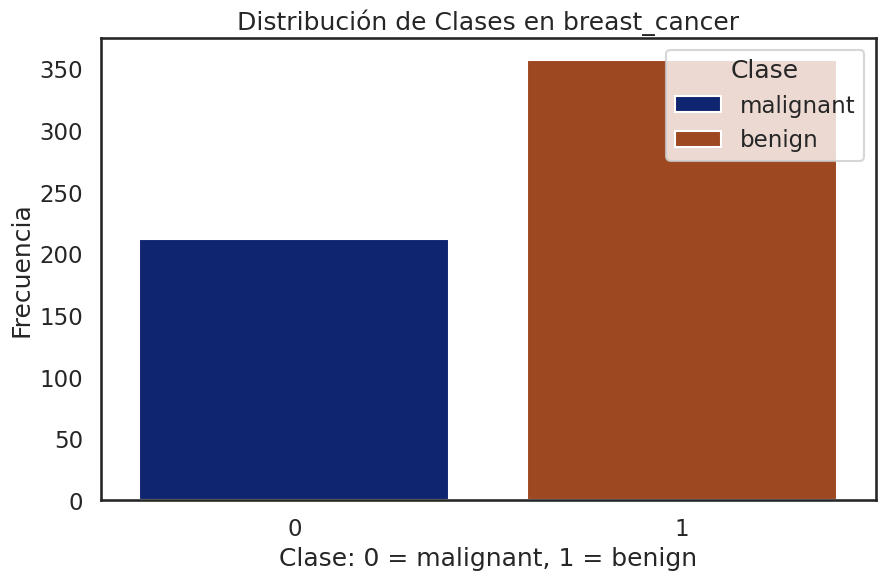


************************************************** Visualización Caract. Principales **************************************************



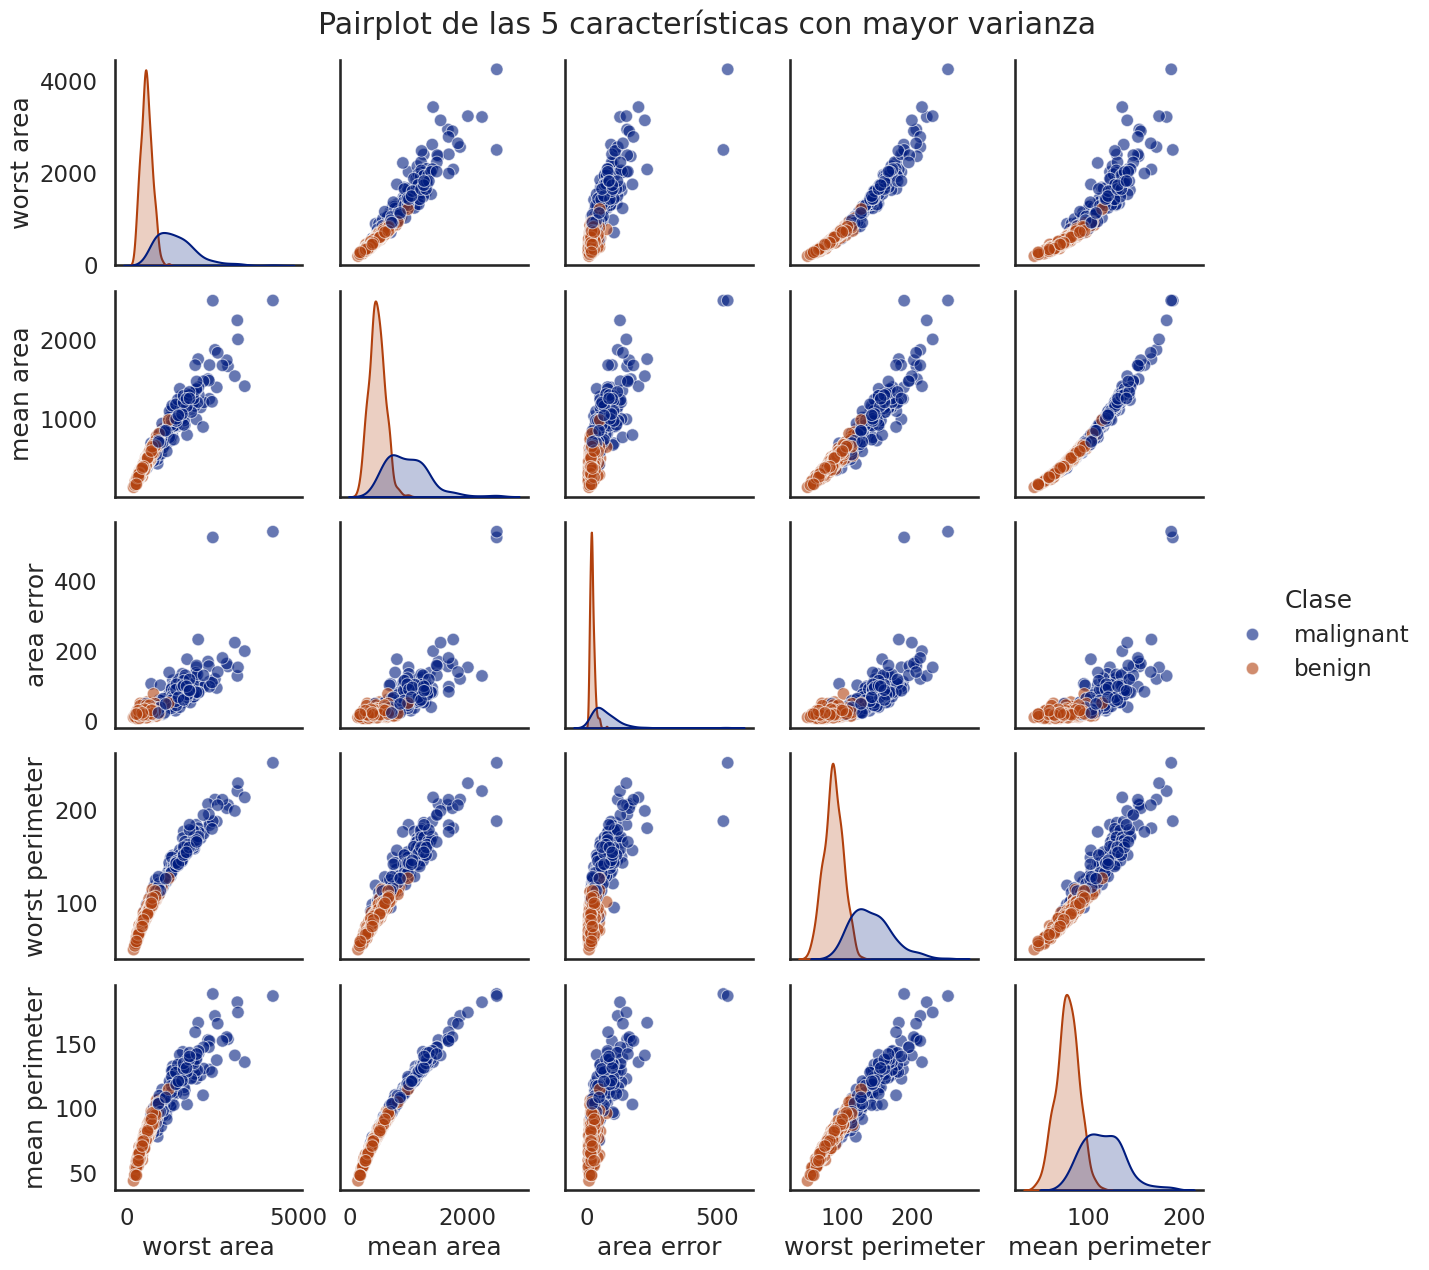

In [107]:
# Carga de librerías y dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE

# Carga del dataset
X, y = load_breast_cancer(return_X_y=True, as_frame=True)

df = pd.concat([X, y], axis=1)
mapeo = {0: 'malignant', 1: 'benign'}
df['target_name'] = df['target'].map(mapeo)
print(df.head())

# Distribución de clases
#    0 = malignant, 1 = benign
clases = df['target'].value_counts()
print('\nDistribución de clases\n', clases)

# Porcentajes
clases_porc = df['target'].value_counts(normalize=True) * 100
print('\nDistribución de clases porcentual\n', clases_porc.round(2))

# Calculo de varianza para detectar las caracteristicas principales
df_num = df.select_dtypes(include=[np.number])

# Se ordenan de mayor a menor
varianzas = df_num.var().sort_values(ascending=False)
print('\nVarianza de las características\n', varianzas)

# Se toman las top 5
top5 = varianzas.index[:5].tolist()
print("\nTop 5 características\n", top5)

print('\n************************************************************ Visualización ************************************************************\n')

# Visualización
plt.figure(figsize=(10, 6))
sns.countplot(x='target', data=df, hue='target_name', legend=True)
plt.title('Distribución de Clases en breast_cancer')
plt.xlabel('Clase: 0 = malignant, 1 = benign')
plt.ylabel('Frecuencia')
plt.legend(title='Clase', loc='upper right')
plt.show()

print('\n************************************************** Visualización Caract. Principales **************************************************\n')
sns.set_context('talk')
sns.set_palette('dark')
sns.set_style('white')
g =sns.pairplot(
    df,
    vars=top5,
    hue='target_name',
    diag_kind='kde',
    plot_kws={'alpha': 0.6}
)
plt.suptitle('Pairplot de las 5 características con mayor varianza', y=1.02)
g._legend.set_title('Clase') # Para agregar el nombre de las series
plt.show()



2. **Entrenamiento base con SVM**
   - Usa un modelo SVM con kernel RBF.
   - Aplica `StratifiedKFold` con 5 particiones.
   - Evalúa con métricas por clase: precisión, recall, F1-score.
   - Calcula y reporta métricas promedio y por clase.


In [108]:
# Preparación de pipeline con escalado
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='rbf', random_state=42))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

resultados = []
cm = [] # Array para guardar las matrices de confusión

# Aplicar StratifiedKFold
for train_index, test_index in cv.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    cm.append(confusion_matrix(y_test, y_pred)) # Guarda las matrices de confusión de cada cv.split
    report = classification_report(y_test, y_pred, output_dict=True)
    resultados.append(report)

df_resultados = []
for resp in resultados:
    # flat para pasar las etiquetas métricas y valor al dataframe
    flat = {}
    for label, metrics in resp.items():
        # Manejamos 'accuracy' separado como si fuera float
        if label == 'accuracy':
            flat[f"{label}"] = metrics
        # Las etiquetas de clase y 'macro avg' que son diccionarios
        elif label in ['0', '1', 'macro avg']:
            for m, v in metrics.items():
                flat[f"{label}_{m}"] = v
    df_resultados.append(flat)

df_final = pd.DataFrame(df_resultados)
# conversion de columna a fila
df_final_T = df_final.transpose()
print(df_final_T.to_string())

# Promedios por clase
promedios = df_final.mean().to_frame('mean_metric')
print('\nPromedio de Métricas\n', promedios)


                              0           1           2           3           4
0_precision            0.977273    0.951220    1.000000    0.976744    1.000000
0_recall               1.000000    0.906977    0.928571    1.000000    0.952381
0_f1-score             0.988506    0.928571    0.962963    0.988235    0.975610
0_support             43.000000   43.000000   42.000000   42.000000   42.000000
1_precision            1.000000    0.945205    0.960000    1.000000    0.972603
1_recall               0.985915    0.971831    1.000000    0.986111    1.000000
1_f1-score             0.992908    0.958333    0.979592    0.993007    0.986111
1_support             71.000000   71.000000   72.000000   72.000000   71.000000
accuracy               0.991228    0.947368    0.973684    0.991228    0.982301
macro avg_precision    0.988636    0.948212    0.980000    0.988372    0.986301
macro avg_recall       0.992958    0.939404    0.964286    0.993056    0.976190
macro avg_f1-score     0.990707    0.943

3. **Análisis del problema de desbalance**
   - Interpreta las métricas: ¿qué clase tiene peor desempeño? ¿por qué?
    - La clase con peor desempeño es la clase 0 (malignant) ya que es la clase minoritaria (37.26% de los datos) por lo que al procesarla en SVM tiene menos ejemplos para obtener su frontera. En este caso `0_recall` es la de peor desempeño con `0.957586`.
   - Reporta matriz de confusión promedio.

Matriz de confusión:
 [[40  1]
 [ 0 70]]


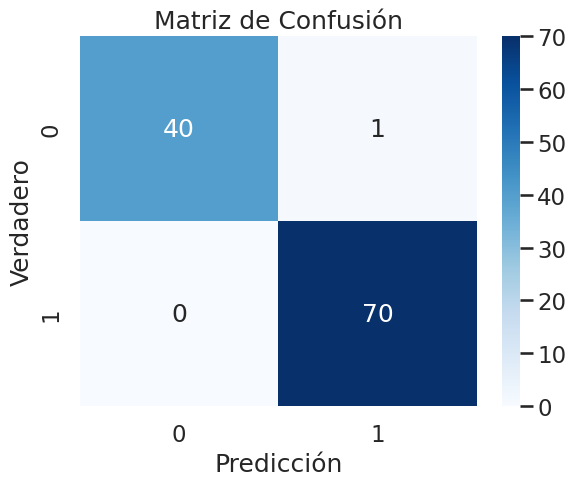

In [109]:
# Matriz de Confusión
# Junta todas las matrices de confusión cms, calcula su promedio y convierte a enteros
prom_cm = np.mean(np.stack(cm), axis=0).astype(int)
print("Matriz de confusión:\n", prom_cm)

# Grafica
sns.heatmap(prom_cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Verdadero')
plt.show()

4. **Aplicación de SMOTE**
   - Aplica `SMOTE` solo al conjunto de entrenamiento dentro de cada fold.
   - Entrena nuevamente la SVM.
   - Compara métricas antes y después.


                              0           1           2           3           4
0_precision            0.954545    0.951220    0.975000    0.933333    1.000000
0_recall               0.976744    0.906977    0.928571    1.000000    0.976190
0_f1-score             0.965517    0.928571    0.951220    0.965517    0.987952
0_support             43.000000   43.000000   42.000000   42.000000   42.000000
1_precision            0.985714    0.945205    0.959459    1.000000    0.986111
1_recall               0.971831    0.971831    0.986111    0.958333    1.000000
1_f1-score             0.978723    0.958333    0.972603    0.978723    0.993007
1_support             71.000000   71.000000   72.000000   72.000000   71.000000
accuracy               0.973684    0.947368    0.964912    0.973684    0.991150
macro avg_precision    0.970130    0.948212    0.967230    0.966667    0.993056
macro avg_recall       0.974288    0.939404    0.957341    0.979167    0.988095
macro avg_f1-score     0.972120    0.943

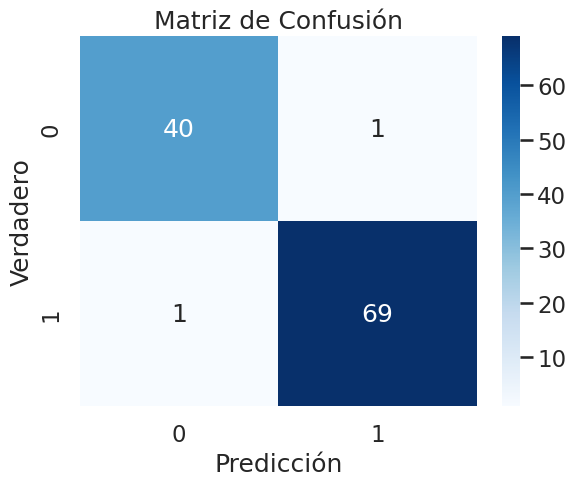

In [110]:
# Re-entrenamiento con smote
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='rbf', random_state=42))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

resultados_smote = []
cms = []

for train_index, test_index in cv.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Aplicación de SMOTE
    smote = SMOTE(random_state=42)
    X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
    # Entrenamiento del modelo
    pipeline.fit(X_train_res, y_train_res)
    y_pred = pipeline.predict(X_test)
    cms.append(confusion_matrix(y_test, y_pred))
    report = classification_report(y_test, y_pred, output_dict=True)
    resultados_smote.append(report)

df_resultados_smote = []
for resp in resultados_smote:
    flat = {}
    for label, metrics in resp.items():
        if label == 'accuracy':
            flat[f"{label}"] = metrics
        elif label in ['0', '1', 'macro avg']:
            for m, v in metrics.items():
                flat[f"{label}_{m}"] = v
    df_resultados_smote.append(flat)

df_final_smote = pd.DataFrame(df_resultados_smote)
# conversion de columna a fila
df_final_smote_T = df_final_smote.transpose()
print(df_final_smote_T.to_string())

promedios_smote = df_final_smote.mean().to_frame('mean_metric_smote')
print('\nPromedio de Métricas\n', promedios_smote)

# Comparacion antes y despues de smote
df_comparacion = pd.concat([promedios, promedios_smote], axis=1)
print('\nComparación de Métricas\n', df_comparacion)

# Matriz de confusión SMOTE
prom_cms = np.mean(np.stack(cms), axis=0).astype(int)
print("\nMatriz de confusión:\n", prom_cms, '\n')

# Grafica
sns.heatmap(prom_cms, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Verdadero')
plt.show()

5. **Visualización y conclusiones**
   - Usa un gráfico de barras comparando F1 por clase antes y después.
   - Comenta las ventajas y riesgos de aplicar SMOTE con SVM.
    - Ventajas:
      - Genera muestras sintéticas que amplían la representación de la clase minoritaria, lo que ayuda al SVM a reducir falsos negativos y a aprender por igual ambas clases.
      - Al equilibrar mejor las clases, el modelo no queda sesgado hacia la mayoría y puede hacer predicciones más confiables.
    - Riesgos:
      - Incrementa el volumen de datos y, por tanto, el tiempo y el coste computacional del entrenamiento.
      - Si la clase minoritaria contiene ruido u outliers, SMOTE puede reproducirlos y empeorar la calidad del conjunto.
      - Existe riesgo de sobreajuste, pues el modelo podría aprender detalles excesivos de los datos sintéticos y generalizar de manera incorrecta.
   - Explica cuándo conviene usar otras técnicas como `One-Sided Selection` o `ADASYN`.
    - `One-Sided Selection (OSS)` es útil si la clase mayoritaria está sobresaturada o contiene muchos ejemplos irrelevantes/ruidosos; en escenarios donde las clases ya están relativamente balanceadas puede aportar poca ganancia.
    - `ADASYN (ADAptive SYNthetic sampling)` conviene usarla cuando la clase minoritaria está muy dispersa o presenta zonas de baja densidad, ya que ADASYN concentra el muestreo sintético donde más falta hace.



               F1_antes  F1_después
malignant (0)  0.968777    0.959755
benign (1)     0.981990    0.976278

**************************************************************************************** Visualización ****************************************************************************************



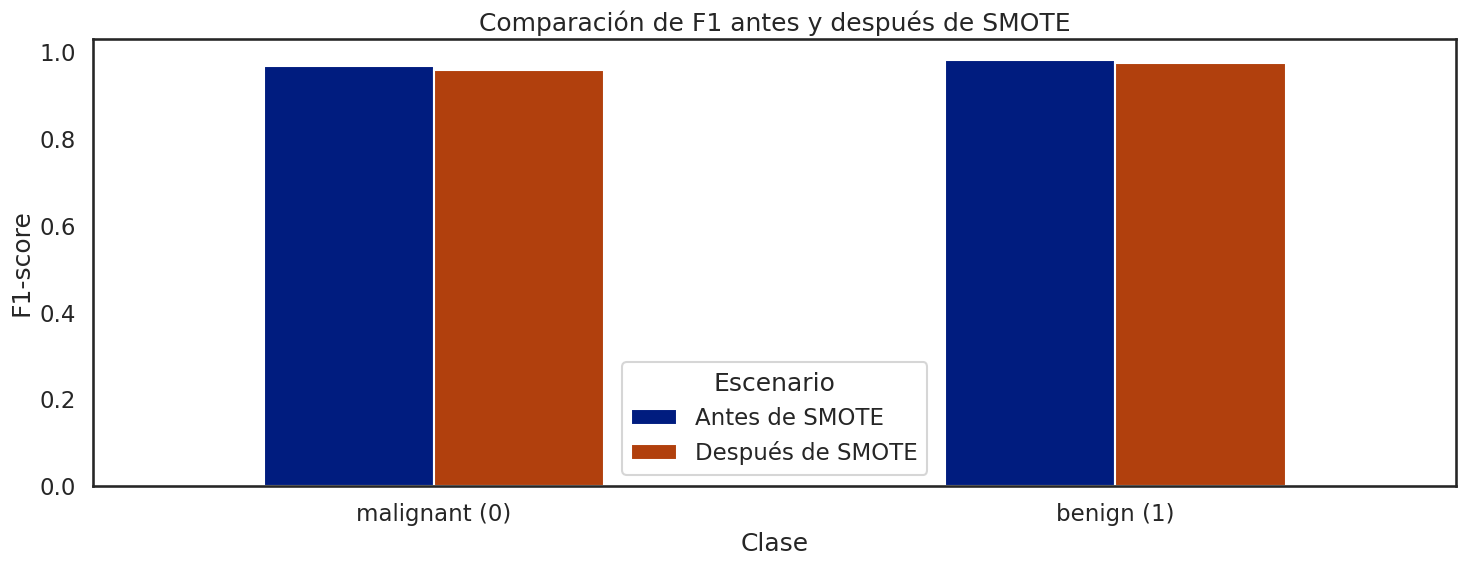

In [111]:
# Gráfico de F1 antes y después
# Sacamos los f1_scores de df_comparación
f1_scores = df_comparacion.loc[['0_f1-score', '1_f1-score']]

# Renombramos índices y columnas
f1_scores.columns = ['F1_antes', 'F1_después']
f1_scores.index = ['malignant (0)', 'benign (1)']
print(f1_scores)

print('\n**************************************************************************************** Visualización ****************************************************************************************\n')

# Graficamos
ax = f1_scores.plot(kind='bar', figsize=(15, 6), rot=0)
ax.set_title('Comparación de F1 antes y después de SMOTE')
ax.set_xlabel('Clase')
ax.set_ylabel('F1-score')
ax.legend(title='Escenario', labels=['Antes de SMOTE', 'Después de SMOTE'])

plt.tight_layout()
plt.show()

**Conclusiones**

Se puede concluir que el balanceo de clases va más allá de aplicar SMOTE, hay que aprender a integrarlo correctamente en la validación cruzada y a evaluar cuándo realmente mejora el modelo. También se aprendió de las alternativas como OSS para depurar la clase mayoritaria y ADASYN para "enfocar" el muestreo sintético en zonas difíciles. El comprobar métrica a métrica y visualizar los resultados ayudó a interpretar el comportamiento del SVM.

## 📁 Entregables

- Google Colab Notebook con:
  - Código bien comentado
  - Gráficas solicitadas
  - Conclusiones reflexivas al final
- Exportación del notebook a PDF
